# Import Libraries

In [44]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
!pip install torchsummary
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

# Ghost Batch Normalization

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

## MODEL


In [0]:
def getBatchNorm(type, num_features, num_splits=2):
  if type == 'GBN':
    return GhostBatchNorm(num_features, num_splits)
  else:
    return nn.BatchNorm2d(num_features)

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self, batch_type):
        super(Net, self).__init__()


        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Utils

In [0]:
def getModel(device, batch_type='BN'):
  model = Net(batch_type).to(device)
  return model

def getDevice():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  return device

def getModelSummary(model):
  summary(model, input_size=(1, 28, 28))

In [0]:
def getDataLoader(batchSize):
  BATCH_SIZE = batchSize
  SEED = 1

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
  return dataloader_args

In [0]:
def L1_Loss(model, loss, l1_factor=0.0005):
    # l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
          # zero_vector = torch.rand_like(param) * 0
          reg_loss += torch.sum(param.abs())

    loss += l1_factor * reg_loss
    return loss

In [0]:
def getTrainDataLoader(dataloader_args):
  # Train Phase transformations
  train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) 
                                        ])
  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
  return train_loader

In [0]:
def getOptimizer(model, lr=0.01, weight_decay=0):
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
  # scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  return optimizer

def train(model, device, train_loader, optimizer, epoch, l1_factor=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_factor:
      print('Inside L1')
      loss = L1_Loss(model, loss)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


In [0]:
def getTestDataLoader(dataloader_args):
  # Test Phase transformations
  test_transforms = transforms.Compose([ transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                        ])
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
  return test_loader

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# 8 Methods



In [0]:
def getMisclassifiedImages(batch_type, modelPath):
  model = Net(batch_type)
  model.load_state_dict(torch.load(modelPath))
  model.cuda()
  model.eval()
  misclassifiedImages = []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)
          target_modified = target.view_as(pred)
          for i in range(len(pred)):
            if pred[i].item()!= target_modified[i].item():
                misclassifiedImages.append([data[i], pred[i], target_modified[i]])

  fig3 = plt.figure(figsize = (25,25))
  for i, im in enumerate(misclassifiedImages[:25]):
      sub = fig3.add_subplot(5, 5, i+1)
      plt.imshow(im[0].cpu().numpy().squeeze(), cmap='gray_r',interpolation='none')
      sub.set_title("Prediction : %s, Actual: %s" % (im[1].data.cpu().numpy()[0], im[2].data.cpu().numpy()[0]))
  plt.tight_layout()
  plt.show()

In [0]:
def saveModel(model, modelPath):
  torch.save(model.state_dict(), modelPath)

In [56]:
!mkdir saved_models

mkdir: cannot create directory ‘saved_models’: File exists


In [84]:
# methods = ['BN','GBN','L1_BN','L1_GBN','L2_BN','L2_GBN','L1_L2_BN','L1_L2_GBN']
methods = ['BN','GBN']

device = getDevice()
EPOCHS = 2
tot_test_losses = {}
tot_test_acc = {}
tot_train_losses = {}
tot_train_acc = {}
l1_factor = 0
l2_weight_decay = 0
for method in methods:
  print("======================================================================= ", method, " ===============================================================================")
  if method == 'BN' or method == 'L1_BN' or method == 'L2_BN' or method == 'L1_L2_BN':
    BATCH_SIZE = 64
    model =  getModel(device, 'BN')
  if method == 'GBN' or method == 'L1_GBN' or method == 'L2_GBN' or method == 'L1_L2_GBN':
    BATCH_SIZE = 128
    model =  getModel(device, 'GBN')
  if method == 'L1_BN' or method == 'L1_GBN' or method == 'L1_L2_BN' or method == 'L1_L2_GBN':
    l1_factor = 0.0005
  else:
    l1_factor = 0
  if method == 'L2_BN' or method == 'L2_GBN' or method == 'L1_L2_BN' or method == 'L1_L2_GBN':
    l2_weight_decay = 0.0005
  else:
    l2_weight_decay = 0

  getModelSummary(model)
  optimizer = getOptimizer(model, 0.01, l2_weight_decay)
  dataLoaderArgs = getDataLoader(BATCH_SIZE)
  train_loader = getTrainDataLoader(dataLoaderArgs)
  test_loader = getTestDataLoader(dataLoaderArgs)
  test_losses = []
  test_acc = []
  train_losses = []
  train_acc = []
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, l1_factor)
      test(model, device, test_loader)
  tot_test_losses[method] = test_losses
  tot_test_acc[method] = test_acc
  tot_train_losses[method] = train_losses
  tot_train_acc[method] = train_acc
  saveModel(model, 'saved_models/'+method+'.pt')

  0%|          | 0/938 [00:00<?, ?it/s]

=======================================================================  BN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        MaxPool2d-11            [-1, 8, 12, 12]               0
          

Loss=0.07141221314668655 Batch_id=937 Accuracy=91.73: 100%|██████████| 938/938 [00:19<00:00, 49.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0620, Accuracy: 9815/10000 (98.15%)

EPOCH: 1


Loss=0.012743338942527771 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:18<00:00, 50.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9889/10000 (98.89%)

=======================================================================  GBN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
    GhostBatchNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        M

Loss=0.13472241163253784 Batch_id=468 Accuracy=85.83: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.12883415818214417 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]



Test set: Average loss: 0.0392, Accuracy: 9878/10000 (98.78%)



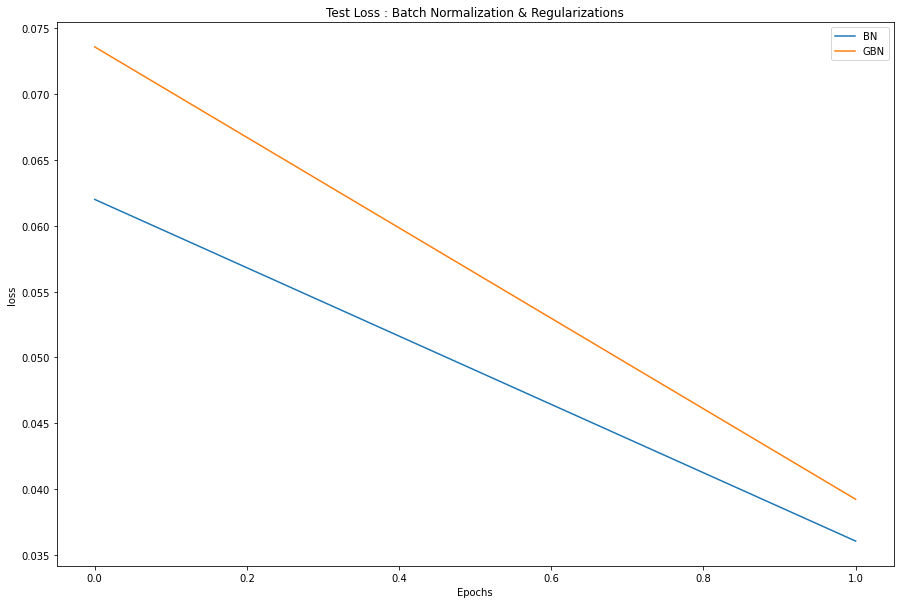

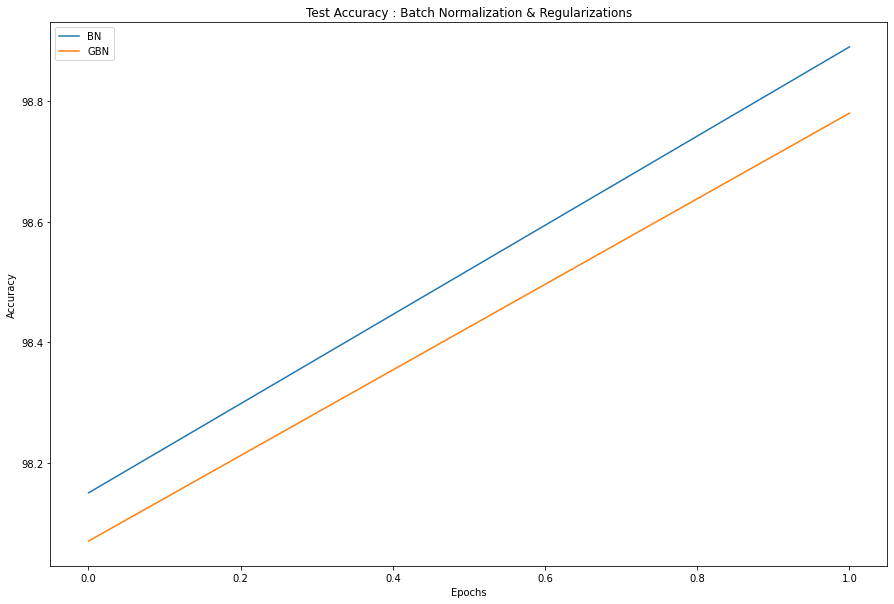

In [85]:
import pandas as pd
testing_all_loss = pd.DataFrame(tot_test_losses)
testing_all_accuracy = pd.DataFrame(tot_test_acc)

fig1 = testing_all_loss.plot(figsize=(15,10), kind = 'line', title = "Test Loss : Batch Normalization & Regularizations")
fig1.set_xlabel("Epochs")
fig1.set_ylabel("loss")

fig2 = testing_all_accuracy.plot(figsize=(15,10), kind = 'line', title = "Test Accuracy : Batch Normalization & Regularizations")
fig2.set_xlabel("Epochs")
fig2.set_ylabel("Accuracy")

fig1
fig2

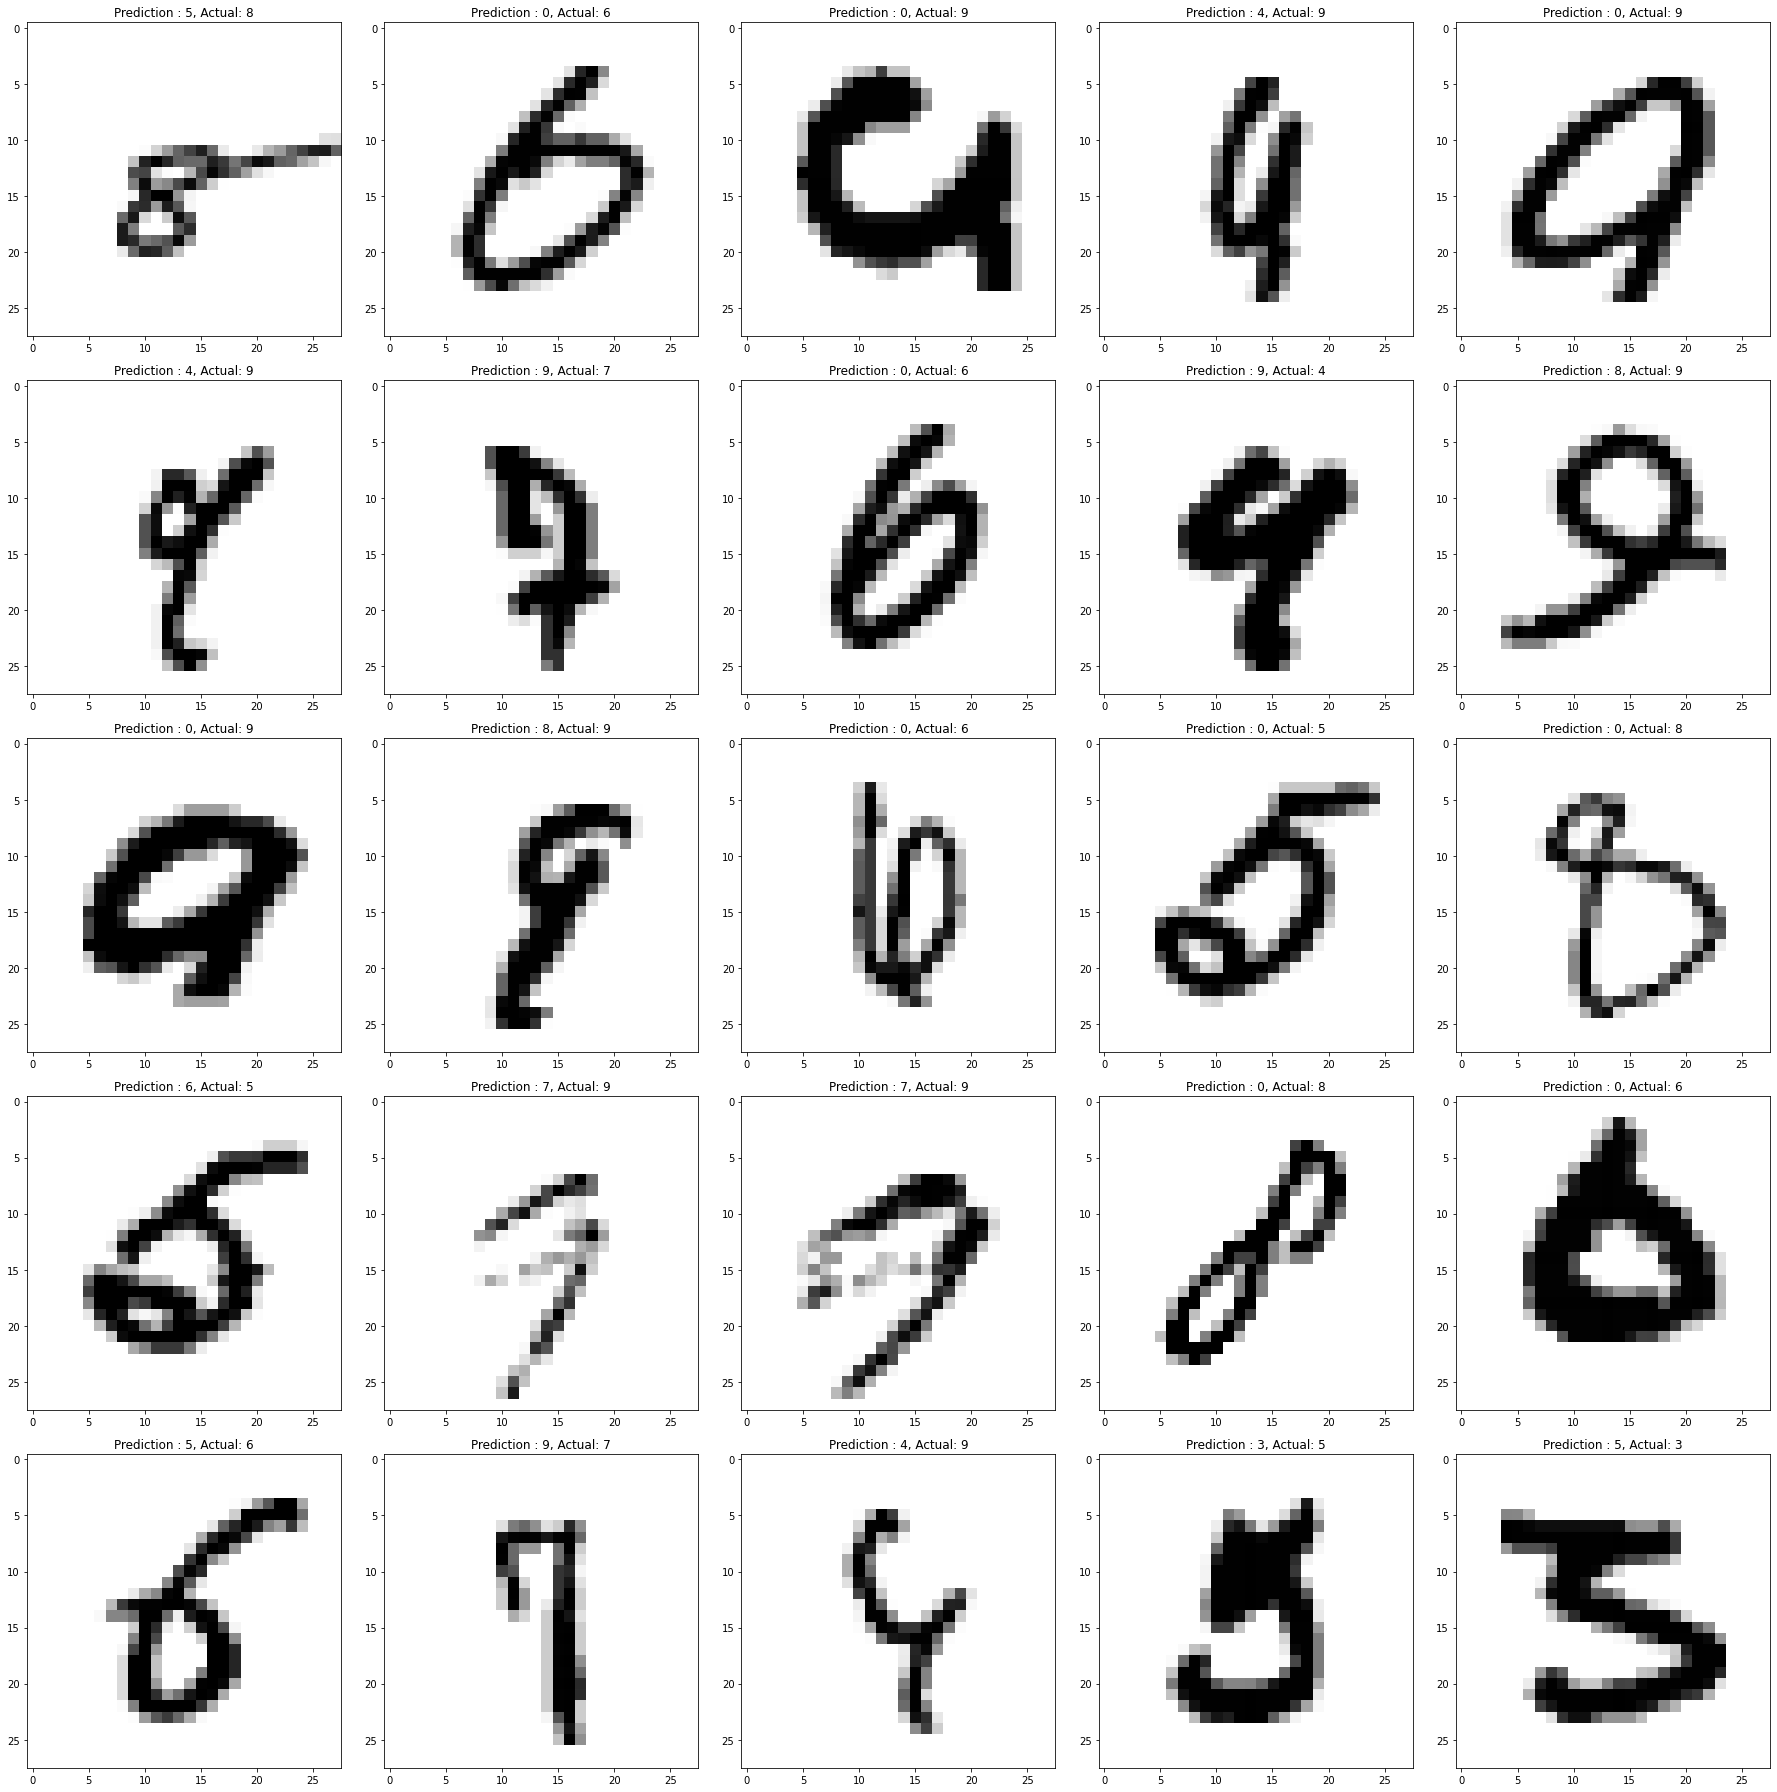

In [86]:
getMisclassifiedImages('BN', 'saved_models/BN.pt')

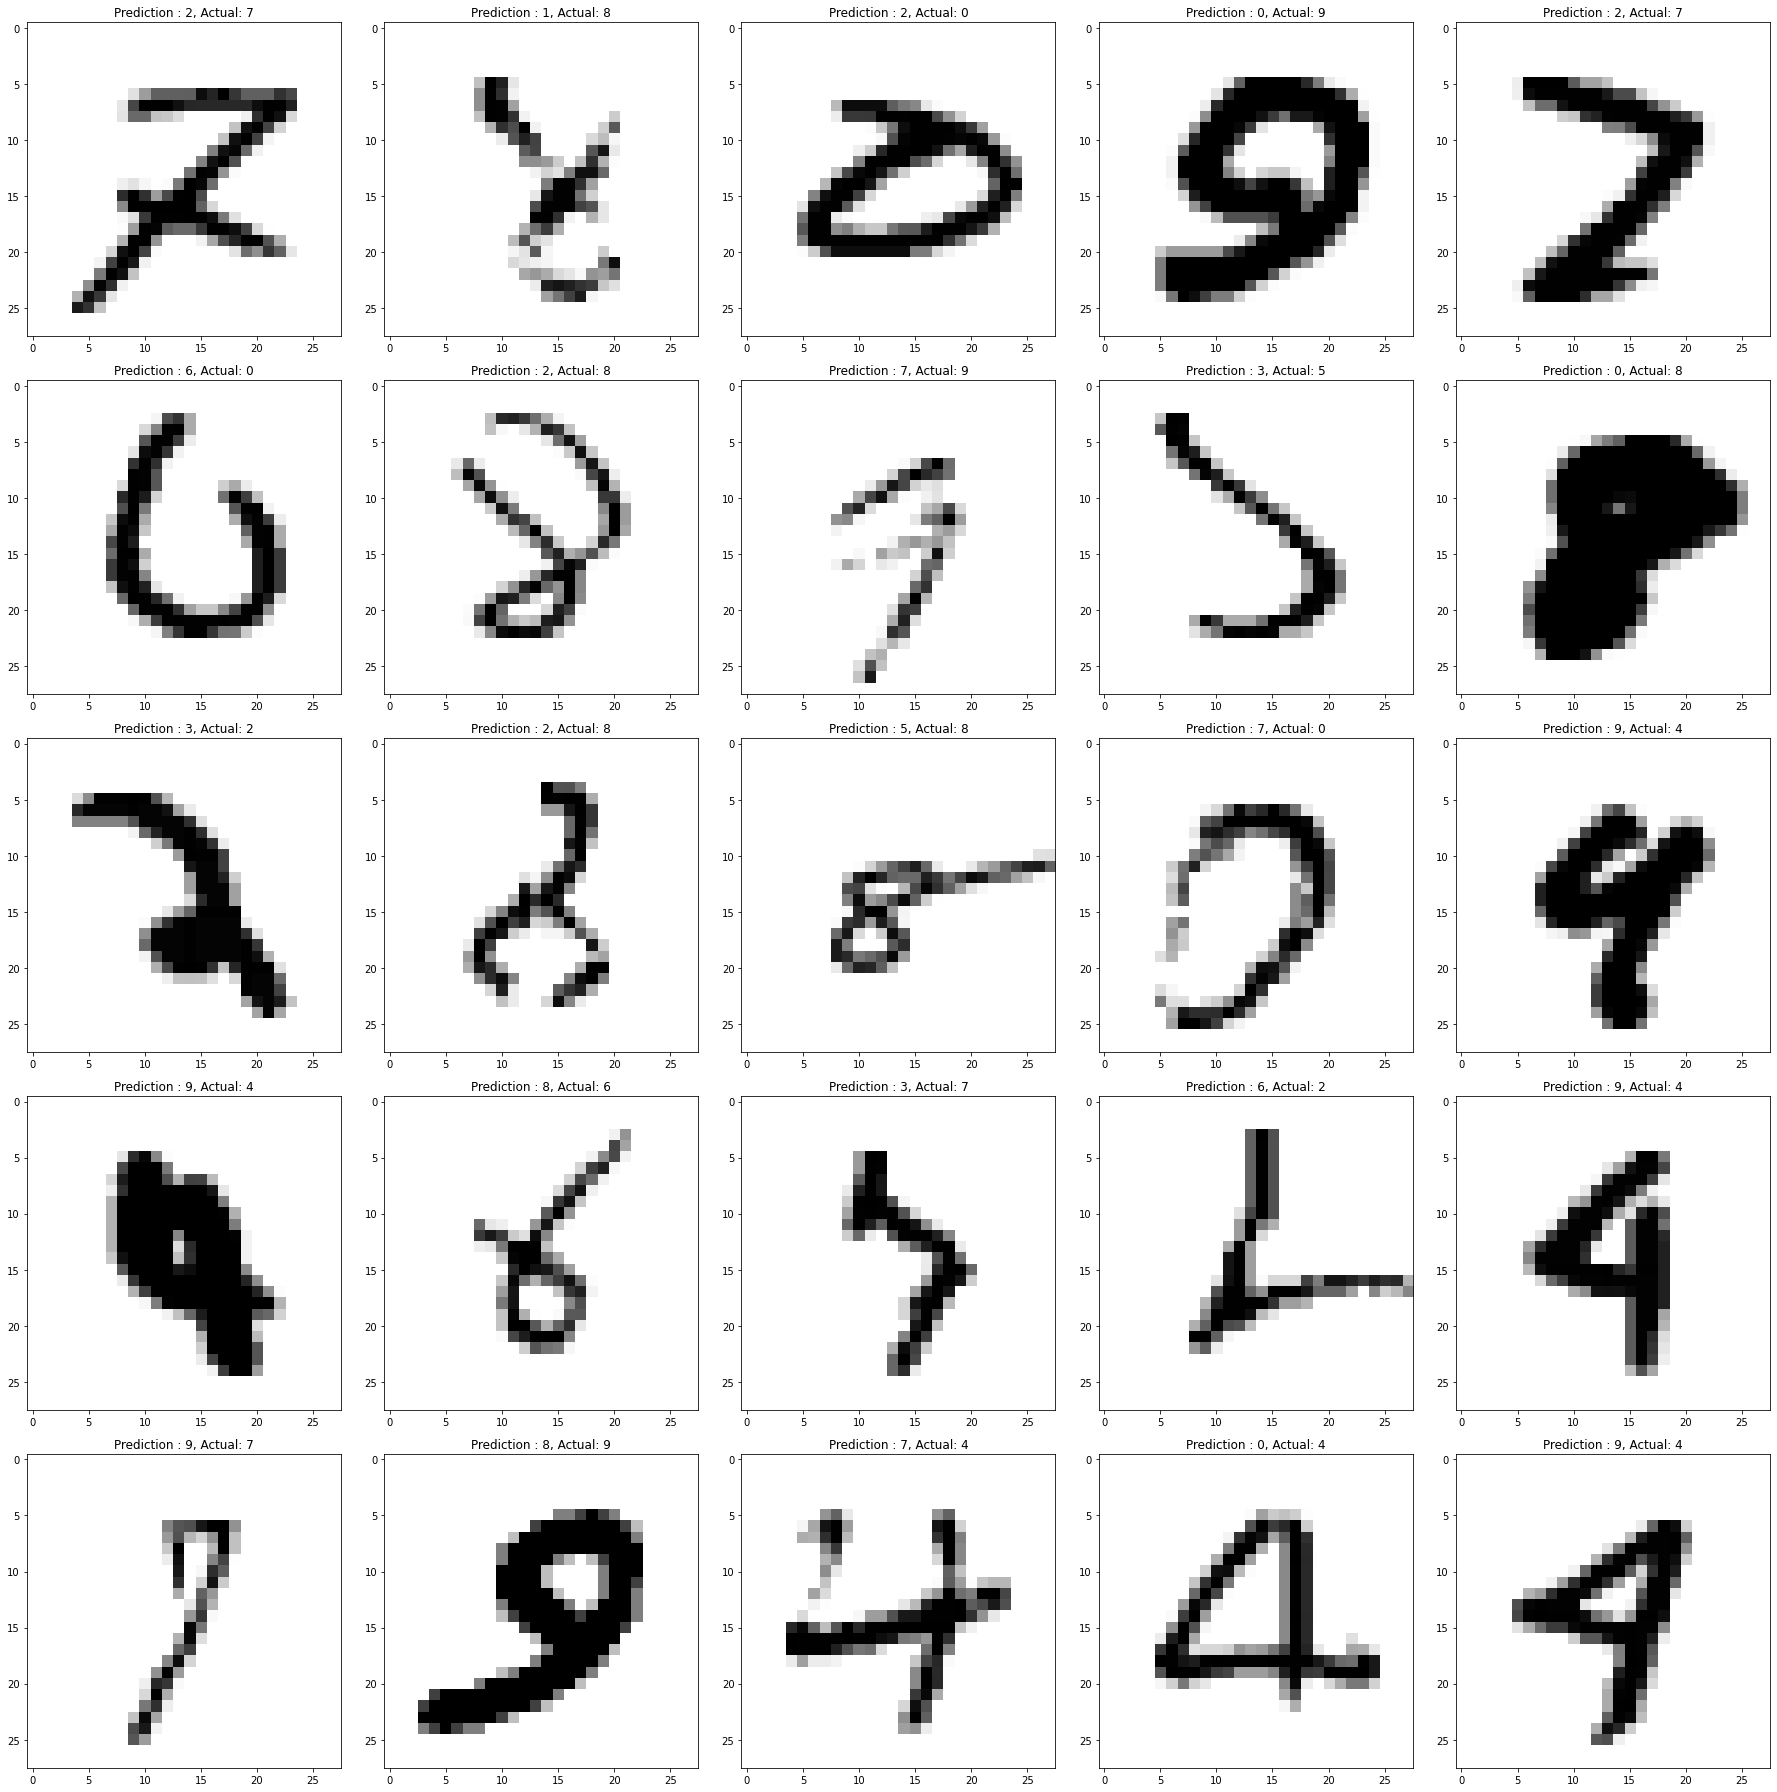

In [87]:
getMisclassifiedImages('GBN','saved_models/GBN.pt')